In [15]:
import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from matplotlib.colors import LogNorm
from scipy.ndimage import shift
from pyathena.util.expand_domain import expand_xy
from scipy.integrate import quad
import matplotlib.transforms as transforms
from astropy.io import fits
from matplotlib.transforms import Bbox
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from scipy.ndimage import map_coordinates
from scipy.spatial import Voronoi
from scipy.spatial import cKDTree
from astropy import constants as const
import astropy.units as u
from scipy.integrate import simpson
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from pts.storedtable.io import readStoredTable
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.ndimage import convolve
from palettable.cubehelix import Cubehelix

palette_HI = Cubehelix.make(start=0.3, rotation=-0.5, n=16).mpl_colormap

pixel_scale_pc = 4.
c = const.c.to('micron/s').value
H_mass_grams = 1.67e-24 # (grams)

def closest_slice(array, number):
    dist = np.abs(array - number)
    indice = np.argmin(dist)
    return indice

output_dir_exp = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded/'
output_dir_norid = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded_norid/'
output_dir_768 = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded_768/'
output_dir_1024 = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded_1024/'
output_dir_Half = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded_Half/'
output_dir_OneHalf = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded_OneHalf/'
gallery_dir = '/export/home/extragal/francesco.chititegli/GALLERY/'
output_dir_convergence = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPEconvergence/'

# Opening Files

In [16]:
image_HI = fits.open(f"{output_dir_convergence}HI_Flux_exp.fits")[0].data
image_HI_norid = fits.open(f"{output_dir_convergence}HI_Flux_norid.fits")[0].data
image_HI_768 = fits.open(f"{output_dir_convergence}HI_Flux_768.fits")[0].data
image_HI_1024 = fits.open(f"{output_dir_convergence}HI_Flux_1024.fits")[0].data

# To convert from erg/s to Jy
wav_A = 21e8
Area_cm2 = 1024**2 * (units.pc**2).to(units.cm**2)
image_HI = 3.34e4 * (wav_A/Area_cm2) * image_HI
image_HI_norid  = 3.34e4 * (wav_A/Area_cm2) * image_HI_norid
image_HI_768 = 3.34e4 * (wav_A/Area_cm2) * image_HI_768
image_HI_1024 = 3.34e4 * (wav_A/Area_cm2) * image_HI_1024

#############################################################################################################

number_surf_dens_HI = fits.open(f"{output_dir_convergence}HI_Surf_exp.fits")[0].data
number_surf_dens_HI_norid = fits.open(f"{output_dir_convergence}HI_Surf_norid.fits")[0].data
number_surf_dens_HI_768 = fits.open(f"{output_dir_convergence}HI_Surf_768.fits")[0].data
number_surf_dens_HI_1024 = fits.open(f"{output_dir_convergence}HI_Surf_1024.fits")[0].data

#############################################################################################################

with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_exp.fits") as hdul: image_Ha = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_norid.fits") as hdul: image_Ha_norid = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_768.fits") as hdul: image_Ha_768 = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_1024.fits") as hdul: image_Ha_1024 = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3

with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_Small.fits") as hdul: image_Ha_Small = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_Half.fits") as hdul: image_Ha_Half = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_ane_i0_total_OneHalf.fits") as hdul: image_Ha_OneHalf = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3

#############################################################################################################

with fits.open(f"{output_dir_convergence}HaTr5_NoDust_i0_total_exp.fits") as hdul: image_Ha_NoDust = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_NoDust_i0_total_norid.fits") as hdul: image_Ha_NoDust_norid = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_NoDust_i0_total_768.fits") as hdul: image_Ha_NoDust_768 = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3
with fits.open(f"{output_dir_convergence}HaTr5_NoDust_i0_total_1024.fits") as hdul: image_Ha_NoDust_1024 = np.squeeze(hdul[0].data.astype(np.float64)) * 1e3

#############################################################################################################

with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_exp.fits") as hdul: image_IR_pre = np.squeeze(hdul[0].data.astype(np.float64))   
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_norid.fits") as hdul: image_IR_norid_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_768.fits") as hdul: image_IR_768_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_1024.fits") as hdul: image_IR_1024_pre = np.squeeze(hdul[0].data.astype(np.float64))

with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_Small.fits") as hdul: image_IR_Small_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_Half.fits") as hdul: image_IR_Half_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_total_OneHalf.fits") as hdul: image_IR_OneHalf_pre = np.squeeze(hdul[0].data.astype(np.float64))

image_IR = np.squeeze(np.sum(image_IR_pre[426:452, :, :], axis=0))
image_IR_norid = np.squeeze(np.sum(image_IR_norid_pre[426:452, :, :], axis=0))
image_IR_768 = np.squeeze(np.sum(image_IR_768_pre[426:452, :, :], axis=0))
image_IR_1024 = np.squeeze(np.sum(image_IR_1024_pre[426:452, :, :], axis=0))

image_IR_Small = np.squeeze(np.sum(image_IR_Small_pre[426:452, :, :], axis=0))
image_IR_Half = np.squeeze(np.sum(image_IR_Half_pre[426:452, :, :], axis=0))
image_IR_OneHalf = np.squeeze(np.sum(image_IR_OneHalf_pre[426:452, :, :], axis=0))

#############################################################################################################

with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_transparent_exp.fits") as hdul:transparent_IR_pre = np.squeeze(hdul[0].data.astype(np.float64))   
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_transparent_norid.fits") as hdul: transparent_IR_norid_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_transparent_768.fits") as hdul: transparent_IR_768_pre = np.squeeze(hdul[0].data.astype(np.float64))
with fits.open(f"{output_dir_convergence}IRTr5_ane_i0_transparent_1024.fits") as hdul: transparent_IR_1024_pre = np.squeeze(hdul[0].data.astype(np.float64))

# From 0.1 to 3 microns
transparent_IR = np.squeeze(np.sum(transparent_IR_pre[8:282, :, :], axis=0))
transparent_IR_norid = np.squeeze(np.sum(transparent_IR_norid_pre[8:282, :, :], axis=0))
transparent_IR_768 = np.squeeze(np.sum(transparent_IR_768_pre[8:282, :, :], axis=0))
transparent_IR_1024 = np.squeeze(np.sum(transparent_IR_1024_pre[8:282, :, :], axis=0))

#############################################################################################################

# These SEDs are natively in MJy/sr, while the wavelengths are in micron
SED_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_exp.dat")
SED_norid_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_norid.dat")
SED_768_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_768.dat")
SED_1024_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_1024.dat")

SED_Small_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_Small.dat")
SED_Half_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_Half.dat")
SED_OneHalf_pre = np.loadtxt(f"{output_dir_convergence}IRTr5_ane_i0_sed_OneHalf.dat")

def convert_fromMJysr_to_ergscm2sr(SED_pre):
    SED_new = np.copy(SED_pre)
    wav_angs = SED_pre[:,0] * 1e4
    for j in np.arange(SED_pre.shape[1]):
        if (j != 0):
            for i in np.arange(SED_pre[:,0].shape[0]):
                SED_new[i,j] = 3e-5 * SED_pre[i,j] / wav_angs[i]
    return SED_new
            
SED = convert_fromMJysr_to_ergscm2sr(SED_pre)
SED_norid = convert_fromMJysr_to_ergscm2sr(SED_norid_pre)
SED_768 = convert_fromMJysr_to_ergscm2sr(SED_768_pre)
SED_1024 = convert_fromMJysr_to_ergscm2sr(SED_1024_pre)

SED_Small = convert_fromMJysr_to_ergscm2sr(SED_Small_pre)
SED_Half = convert_fromMJysr_to_ergscm2sr(SED_Half_pre)
SED_OneHalf = convert_fromMJysr_to_ergscm2sr(SED_OneHalf_pre)

In [17]:
print('Mean 21 cm 256 pc [Jy] :  ' + str(np.nanmean(image_HI)))
print('Mean 21 cm 512 pc [Jy] :  ' + str(np.nanmean(image_HI_norid)))
print('Mean 21 cm 768 pc [Jy] :  ' + str(np.nanmean(image_HI_768)))
print('Mean 21 cm 1024 pc [Jy] : ' + str(np.nanmean(image_HI_1024)))
print()
print('Mean Ha 256 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha)))
print('Mean Ha 512 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_norid)))
print('Mean Ha 768 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_768)))
print('Mean Ha 1024 pc [erg/s/cm2/arcsec2] : ' + str(np.nanmean(image_Ha_1024)))
print('Mean Ha 2 1x1 [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_Small)))
print('Mean Ha 2  2x2 [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_Half)))
print('Mean Ha 4x4  [erg/s/cm2/arcsec2] : ' + str(np.nanmean(image_Ha_OneHalf)))
print()
print('NO DUST Mean Ha 256 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_NoDust)))
print('NO DUST Mean Ha 512 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_NoDust_norid)))
print('NO DUST Mean Ha 768 pc [erg/s/cm2/arcsec2] :  ' + str(np.nanmean(image_Ha_NoDust_768)))
print('NO DUST Mean Ha 1024 pc [erg/s/cm2/arcsec2] : ' + str(np.nanmean(image_Ha_NoDust_1024)))
print()
print('Mean IR 256 pc [MJy/sr] :  ' + str(np.nanmean(image_IR)))
print('Mean IR 512 pc [MJy/sr] :  ' + str(np.nanmean(image_IR_norid)))
print('Mean IR 768 pc [MJy/sr] :  ' + str(np.nanmean(image_IR_768)))
print('Mean IR 1024 pc [MJy/sr] : ' + str(np.nanmean(image_IR_1024)))
print('Mean IR 1x1  [MJy/sr] :    ' + str(np.nanmean(image_IR_Small)))
print('Mean IR 2x2  [MJy/sr] :    ' + str(np.nanmean(image_IR_Half)))
print('Mean IR 4x4  [MJy/sr] :    ' + str(np.nanmean(image_IR_OneHalf)))
print()
print('SED-extr Secodary transparent IR 256 pc [MJy/sr] :  ' + str(np.sum(SED_pre[426:452, 6], axis=0) * 1e-6 / (3*1024/1e7)**2))
print('SED-extr Secodary transparent IR 512 pc [MJy/sr] :  ' + str(np.sum(SED_norid_pre[426:452, 6], axis=0)* 1e-6 / (3*1024/1e7)**2))
print('SED-extr Secodary transparent IR 768 pc [MJy/sr] :  ' + str(np.sum(SED_768_pre[426:452, 6], axis=0)* 1e-6 / (3*1024/1e7)**2))
print('SED-extr Secodary transparent IR 1024 pc [MJy/sr] : ' + str(np.sum(SED_1024_pre[426:452, 6], axis=0)* 1e-6 / (3*1024/1e7)**2))

Mean 21 cm 256 pc [Jy] :  0.012530558361546663
Mean 21 cm 512 pc [Jy] :  0.014342561109566443
Mean 21 cm 768 pc [Jy] :  0.014612456565355756
Mean 21 cm 1024 pc [Jy] : 0.014633972729177349

Mean Ha 256 pc [erg/s/cm2/arcsec2] :  1.2137294689692801e-17
Mean Ha 512 pc [erg/s/cm2/arcsec2] :  1.2140487438210613e-17
Mean Ha 768 pc [erg/s/cm2/arcsec2] :  1.2055808711402113e-17
Mean Ha 1024 pc [erg/s/cm2/arcsec2] : 1.2006709902716521e-17
Mean Ha 2 1x1 [erg/s/cm2/arcsec2] :  1.1088941698984581e-17
Mean Ha 2  2x2 [erg/s/cm2/arcsec2] :  1.182914760503808e-17
Mean Ha 4x4  [erg/s/cm2/arcsec2] : 1.2141748422643299e-17

NO DUST Mean Ha 256 pc [erg/s/cm2/arcsec2] :  1.5646686027821065e-17
NO DUST Mean Ha 512 pc [erg/s/cm2/arcsec2] :  1.6033300168716793e-17
NO DUST Mean Ha 768 pc [erg/s/cm2/arcsec2] :  1.6096135049294758e-17
NO DUST Mean Ha 1024 pc [erg/s/cm2/arcsec2] : 1.6108096097007227e-17

Mean IR 256 pc [MJy/sr] :  66.4938543245969
Mean IR 512 pc [MJy/sr] :  66.48033274590568
Mean IR 768 pc [MJy/sr

# Vertical Convergence

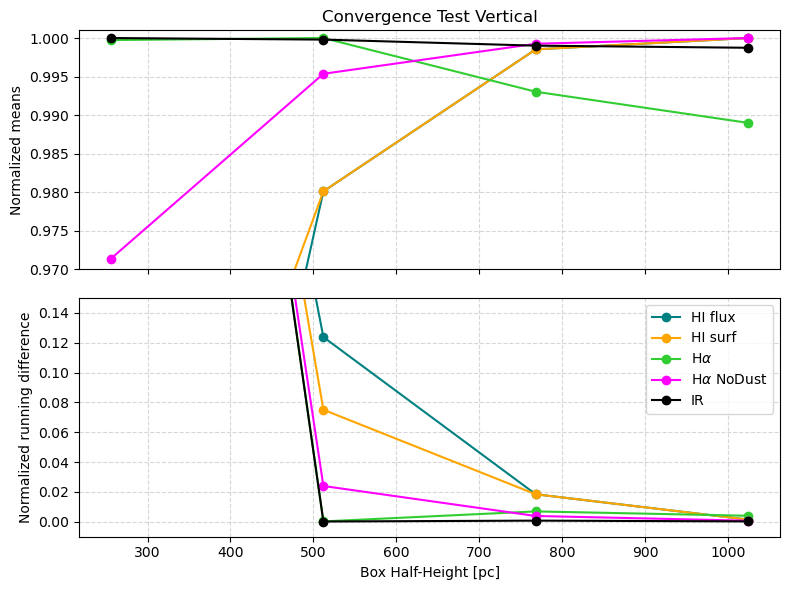

In [12]:
thicknesses = [256, 512, 768, 1024]
means_flux_HI = [np.mean(image_HI), np.mean(image_HI_norid), np.mean(image_HI_768), np.mean(image_HI_1024)]
means_surf_HI = [np.mean(number_surf_dens_HI), np.mean(number_surf_dens_HI_norid), np.mean(number_surf_dens_HI_768), np.mean(number_surf_dens_HI_1024)]
means_Ha = [np.mean(image_Ha), np.mean(image_Ha_norid), np.mean(image_Ha_768), np.mean(image_Ha_1024)]
means_Ha_NoDust = [np.mean(image_Ha_NoDust), np.mean(image_Ha_NoDust_norid), np.mean(image_Ha_NoDust_768), np.mean(image_Ha_NoDust_1024)]
means_IR = [np.mean(image_IR), np.mean(image_IR_norid), np.mean(image_IR_768), np.mean(image_IR_1024)]

norm_flux_HI = [x/max(means_flux_HI) for x in means_flux_HI]
norm_surf_HI = [x/max(means_surf_HI) for x in means_surf_HI]
norm_Ha = [x/max(means_Ha) for x in means_Ha]
norm_Ha_NoDust = [x/max(means_Ha_NoDust) for x in means_Ha_NoDust]
norm_IR = [x/max(means_IR) for x in means_IR]

diffs_flux_HI = [norm_flux_HI[0]] + [abs(j - i) for i, j in zip(norm_flux_HI[:-1], norm_flux_HI[1:])]
diffs_surf_HI = [norm_surf_HI[0]] + [abs(j - i) for i, j in zip(norm_surf_HI[:-1], norm_surf_HI[1:])]
diffs_Ha = [norm_Ha[0]] + [abs(j - i) for i, j in zip(norm_Ha[:-1], norm_Ha[1:])]
diffs_Ha_NoDust = [norm_Ha_NoDust[0]] + [abs(j - i) for i, j in zip(norm_Ha_NoDust[:-1], norm_Ha_NoDust[1:])]
diffs_IR = [norm_IR[0]] + [abs(j - i) for i, j in zip(norm_IR[:-1], norm_IR[1:])]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, dpi=100)

ax[0].plot(thicknesses, norm_flux_HI, marker='o', linestyle='-', color='teal', label='HI flux')
ax[0].plot(thicknesses, norm_surf_HI, marker='o', linestyle='-', color='orange', label='HI surf')
ax[0].plot(thicknesses, norm_Ha, marker='o', linestyle='-', color='limegreen', label='Ha')
ax[0].plot(thicknesses, norm_Ha_NoDust, marker='o', linestyle='-', color='magenta', label='Ha NoDust')
ax[0].plot(thicknesses, norm_IR, marker='o', linestyle='-', color='black', label='IR')
ax[0].set_ylabel('Normalized means')
ax[0].set_title('Convergence Test Vertical')
#ax[0].set_yscale('log')
ax[0].set_ylim(0.97,1.001)
ax[0].grid(True, which='both', linestyle='--', alpha=0.5)

ax[1].plot(thicknesses, diffs_flux_HI, marker='o', linestyle='-', color='teal', label='HI flux')
ax[1].plot(thicknesses, diffs_surf_HI, marker='o', linestyle='-', color='orange', label='HI surf')
ax[1].plot(thicknesses, diffs_Ha, marker='o', linestyle='-', color='limegreen', label=r'H$\alpha$')
ax[1].plot(thicknesses, diffs_Ha_NoDust, marker='o', linestyle='-', color='magenta', label=r'H$\alpha$ NoDust')
ax[1].plot(thicknesses, diffs_IR, marker='o', linestyle='-', color='black', label='IR')
ax[1].set_xlabel('Box Half-Height [pc]')
ax[1].set_ylabel('Normalized running difference')
#ax[1].set_yscale('log')
ax[1].set_ylim(-0.01,0.15)
ax[1].grid(True, which='both', linestyle='--', alpha=0.5)
ax[1].legend()

plt.tight_layout()
plt.savefig(f"{gallery_dir}Convergence_Ver.jpeg", format='jpeg', dpi=100)
plt.show()


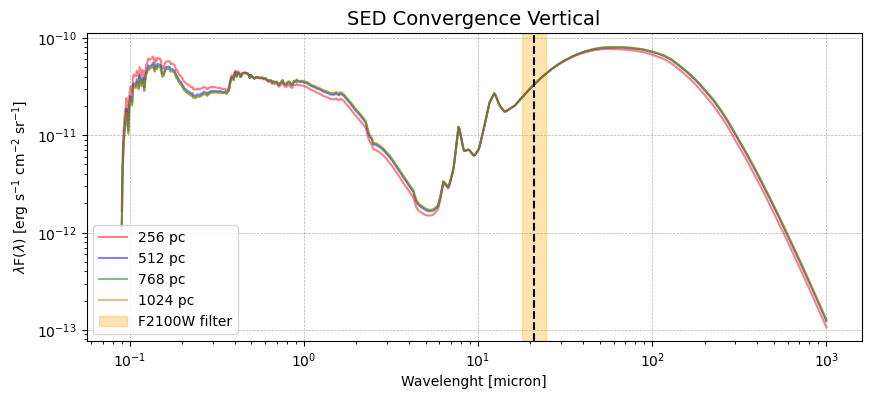

In [27]:
plt.figure(figsize=(10, 4), dpi = 100)

plt.plot(SED[:,0], SED[:,1], color="red", label='256 pc', alpha=0.5)
plt.plot(SED[:,0], SED_norid[:,1], color="blue", label='512 pc', alpha=0.5)
plt.plot(SED[:,0], SED_768[:,1], color="green", label='768 pc', alpha=0.5)
plt.plot(SED[:,0], SED_1024[:,1], color="darkgoldenrod", label='1024 pc', alpha=0.5)

plt.xlabel("Wavelenght [micron]")
plt.ylabel(r"$\lambda$F($\lambda$) [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$]")
plt.title("SED Convergence Vertical", fontsize=14)
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-11,1e-10)
plt.axvspan(17.907784, 24.478051, color='orange', alpha=0.3, label='F2100W filter')
plt.axvline(x=21, color='black', linestyle='--')
#plt.axhline(y=0.02531833, color='black', linestyle='--')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower left')
plt.show()

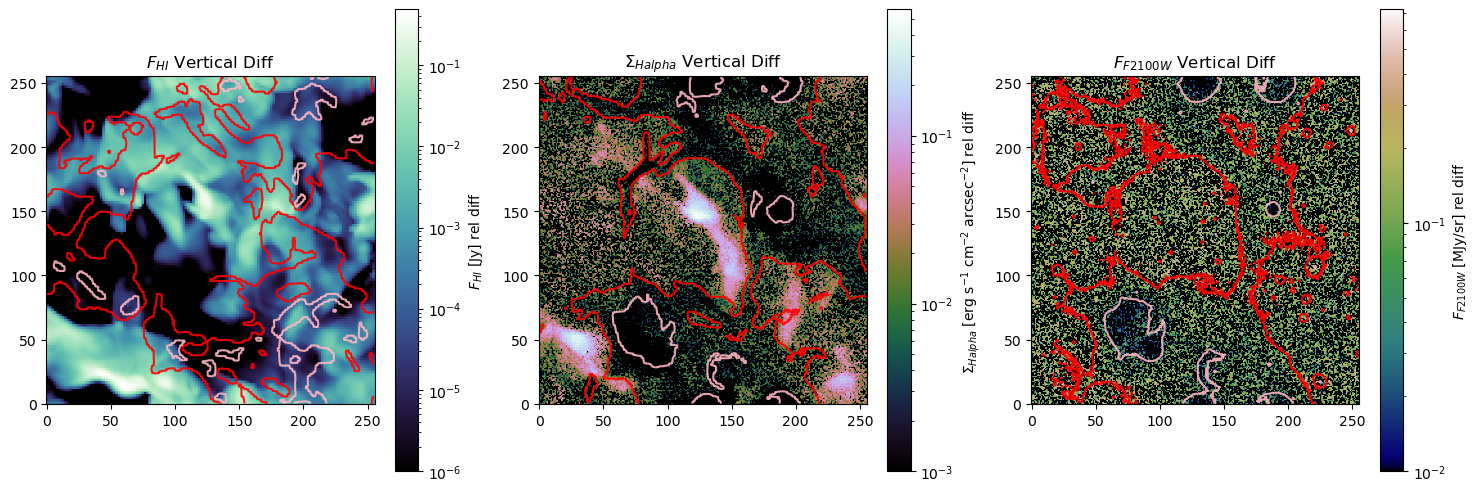

Rel diff HI. Max: 0.4910581742364038  Min: 8.227201709275849e-12  Mean: 0.006082788069624988
Rel diff Ha. Max: 0.5696737481684934  Min: -0.13818569878983628  Mean: 0.008467869673661753
Rel diff IR. Max: 0.7263700632551818  Min: -3.161629150081963  Mean: -0.02992734033236265


In [20]:
difference_HI = (image_HI_1024 - image_HI_768) / image_HI_1024
difference_Ha = (image_Ha_1024 - image_Ha_768) / image_Ha_1024
difference_IR = (image_IR_1024 - image_IR_768) / image_IR_1024

levels_HI = [np.nanpercentile(image_HI_1024, 55), np.nanpercentile(image_HI_1024, 95)]
levels_Ha = [np.nanpercentile(image_Ha_1024, 55), np.nanpercentile(image_Ha_1024, 95)]
levels_IR = [np.nanpercentile(image_IR_1024, 55), np.nanpercentile(image_IR_1024, 95)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

palette = plt.cm.cubehelix.with_extremes(bad='k')
im1 = axes[0].imshow(difference_HI, cmap=palette_HI, origin='lower', norm=LogNorm(vmin=1e-6))
cont1 = axes[0].contour(image_HI_1024, levels=levels_HI, norm=LogNorm(), colors=['red', 'lightpink'], alpha=0.9)
cbar = plt.colorbar(im1, ax=axes[0])
cbar.set_label(r'$F$$_{HI}$ [Jy] rel diff')
axes[0].set_title(r'$F$$_{HI}$ Vertical Diff')

palette = plt.cm.cubehelix.with_extremes(bad='k')
im2 = axes[1].imshow(difference_Ha, cmap=palette, origin='lower', norm=LogNorm(vmin=1e-3))
cont2 = axes[1].contour(image_Ha_1024, levels=levels_Ha, norm=LogNorm(), colors=['red', 'lightpink'], alpha=0.9)
cbar = plt.colorbar(im2, ax=axes[1])
cbar.set_label(r'$\Sigma$$_{Halpha}$ [erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$] rel diff')
axes[1].set_title(r'$\Sigma$$_{Halpha}$ Vertical Diff')

palette = plt.cm.gist_earth.with_extremes(bad='k')
im3 = axes[2].imshow(difference_IR, cmap=palette, origin='lower', norm=LogNorm(vmin=1e-2))
cont3 = axes[2].contour(image_IR_1024, levels=levels_IR, norm=LogNorm(), colors=['red', 'lightpink'], alpha=0.9)
cbar = plt.colorbar(im3, ax=axes[2])
cbar.set_label(r'$F$$_{F2100W}$ [MJy/sr] rel diff')
axes[2].set_title(r'$F$$_{F2100W}$ Vertical Diff')

plt.savefig(f"{gallery_dir}Convergence_Ver_LastTwo.jpeg", format='jpeg', dpi=100)

plt.show()

print('Rel diff HI. Max: ' + str(np.nanmax(difference_HI)) + '  Min: ' + str(np.nanmin(difference_HI)) + '  Mean: ' + str(np.nanmean(difference_HI)))
print('Rel diff Ha. Max: ' + str(np.nanmax(difference_Ha)) + '  Min: ' + str(np.nanmin(difference_Ha)) + '  Mean: ' + str(np.nanmean(difference_Ha)))
print('Rel diff IR. Max: ' + str(np.nanmax(difference_IR)) + '  Min: ' + str(np.nanmin(difference_IR)) + '  Mean: ' + str(np.nanmean(difference_IR)))

# Horizontal Convergence

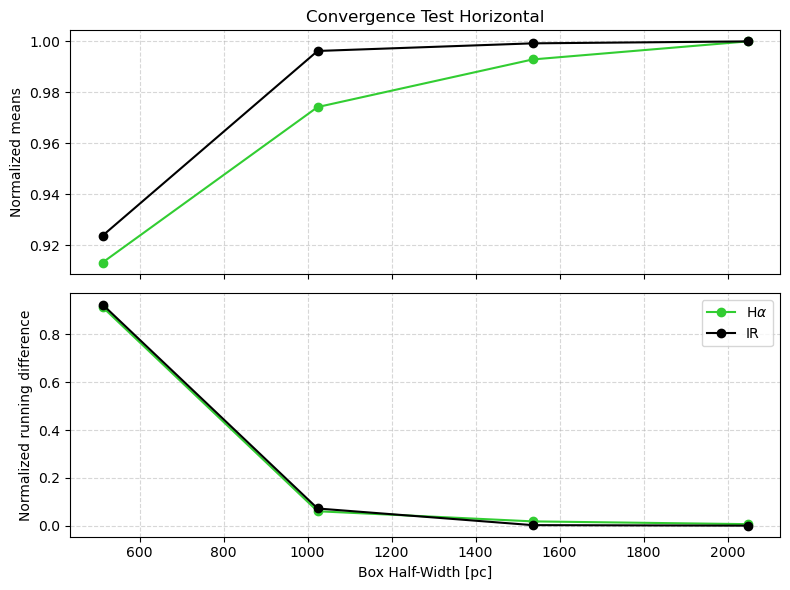

In [5]:
widths = [512, 1024, 1536, 2048] # The expanded width is in pc, is the half length of the box bases
means_Ha = [np.mean(image_Ha_Small), np.mean(image_Ha_Half), np.mean(image_Ha_768), np.mean(image_Ha_OneHalf)]
means_IR = [np.mean(image_IR_Small), np.mean(image_IR_Half), np.mean(image_IR_768), np.mean(image_IR_OneHalf)]

norm_Ha = [x/max(means_Ha) for x in means_Ha]
norm_IR = [x/max(means_IR) for x in means_IR]

diffs_Ha = [norm_Ha[0]] + [abs(j - i) for i, j in zip(norm_Ha[:-1], norm_Ha[1:])]
diffs_IR = [norm_IR[0]] + [abs(j - i) for i, j in zip(norm_IR[:-1], norm_IR[1:])]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, dpi=100)

ax[0].plot(widths, norm_Ha, marker='o', linestyle='-', color='limegreen', label='Ha')
ax[0].plot(widths, norm_IR, marker='o', linestyle='-', color='black', label='IR')
ax[0].set_ylabel('Normalized means')
ax[0].set_title('Convergence Test Horizontal')
#ax[0].set_yscale('log')
#ax[0].set_ylim(0.97,1.001)
ax[0].grid(True, which='both', linestyle='--', alpha=0.5)

ax[1].plot(widths, diffs_Ha, marker='o', linestyle='-', color='limegreen', label=r'H$\alpha$')
ax[1].plot(widths, diffs_IR, marker='o', linestyle='-', color='black', label='IR')
ax[1].set_xlabel('Box Half-Width [pc]')
ax[1].set_ylabel('Normalized running difference')
#ax[1].set_yscale('log')
#ax[1].set_ylim(-0.01,0.15)
ax[1].grid(True, which='both', linestyle='--', alpha=0.5)
ax[1].legend()

plt.tight_layout()
plt.savefig(f"{gallery_dir}Convergence_Hor.jpeg", format='jpeg', dpi=100)
plt.show()

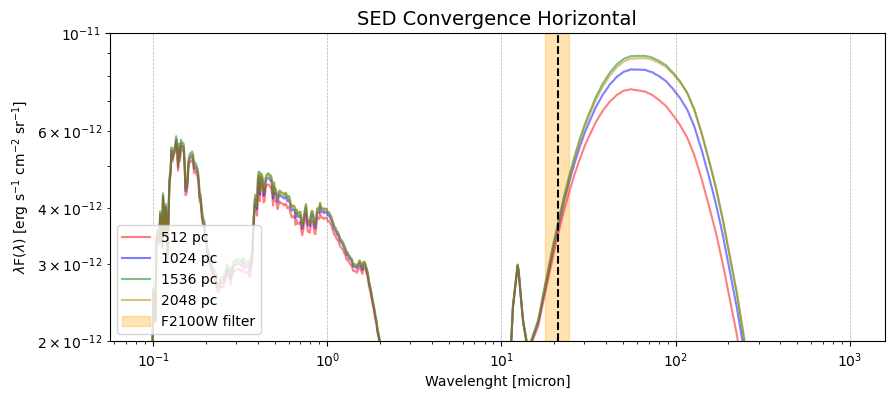

In [6]:
plt.figure(figsize=(10, 4), dpi = 100)

plt.plot(SED[:,0], SED_Small[:,1], color="red", label='512 pc', alpha=0.5)
plt.plot(SED[:,0], SED_Half[:,1]/4, color="blue", label='1024 pc', alpha=0.5)
plt.plot(SED[:,0], SED_768[:,1]/9, color="green", label='1536 pc', alpha=0.5)
plt.plot(SED[:,0], SED_OneHalf[:,1]/16, color="darkgoldenrod", label='2048 pc', alpha=0.5)

plt.xlabel("Wavelenght [micron]")
plt.ylabel(r"$\lambda$F($\lambda$) [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$]")
plt.title("SED Convergence Horizontal", fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.ylim(2e-12,1e-11)
plt.axvspan(17.907784, 24.478051, color='orange', alpha=0.3, label='F2100W filter')
plt.axvline(x=21, color='black', linestyle='--')
#plt.axhline(y=0.02531833, color='black', linestyle='--')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower left')
plt.show()

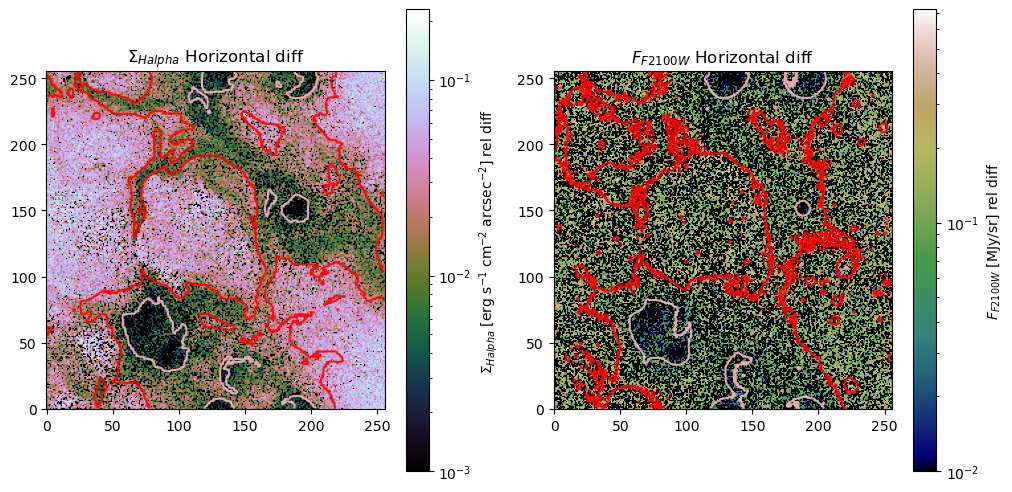

Rel diff Ha. Max: 0.22967518128427653  Min: -0.1939441082121586  Mean: 0.025863175582762316
Rel diff IR. Max: 0.7227591552294006  Min: -4.973253383230315  Mean: -0.01941934633179947


In [25]:
difference_Ha = (image_Ha_OneHalf - image_Ha_768) / image_Ha_OneHalf
difference_IR = (image_IR_OneHalf - image_IR_768) / image_IR_OneHalf

levels_Ha = [np.nanpercentile(image_Ha_OneHalf, 55), np.nanpercentile(image_Ha_OneHalf, 95)]
levels_IR = [np.nanpercentile(image_IR_OneHalf, 55), np.nanpercentile(image_IR_OneHalf, 95)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

palette = plt.cm.cubehelix.with_extremes(bad='k')
im2 = axes[0].imshow(difference_Ha, cmap=palette, origin='lower', norm=LogNorm(vmin=1e-3))
cont2 = axes[0].contour(image_Ha_OneHalf, levels=levels_Ha, norm=LogNorm(), colors=['red', 'lightpink'], alpha=0.9)
cbar = plt.colorbar(im2, ax=axes[0])
cbar.set_label(r'$\Sigma$$_{Halpha}$ [erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$] rel diff')
axes[0].set_title(r'$\Sigma$$_{Halpha}$ Horizontal diff')

palette = plt.cm.gist_earth.with_extremes(bad='k')
im3 = axes[1].imshow(difference_IR, cmap=palette, origin='lower', norm=LogNorm(vmin=1e-2))
cont3 = axes[1].contour(image_IR_OneHalf, levels=levels_IR, norm=LogNorm(), colors=['red', 'lightpink'], alpha=0.9)
cbar = plt.colorbar(im3, ax=axes[1])
cbar.set_label(r'$F$$_{F2100W}$ [MJy/sr] rel diff')
axes[1].set_title(r'$F$$_{F2100W}$ Horizontal diff')

plt.savefig(f"{gallery_dir}Convergence_Hor_LastTwo.jpeg", format='jpeg', dpi=100)

plt.show()

print('Rel diff Ha. Max: ' + str(np.nanmax(difference_Ha)) + '  Min: ' + str(np.nanmin(difference_Ha)) + '  Mean: ' + str(np.nanmean(difference_Ha)))
print('Rel diff IR. Max: ' + str(np.nanmax(difference_IR)) + '  Min: ' + str(np.nanmin(difference_IR)) + '  Mean: ' + str(np.nanmean(difference_IR)))

# Leroy 2023

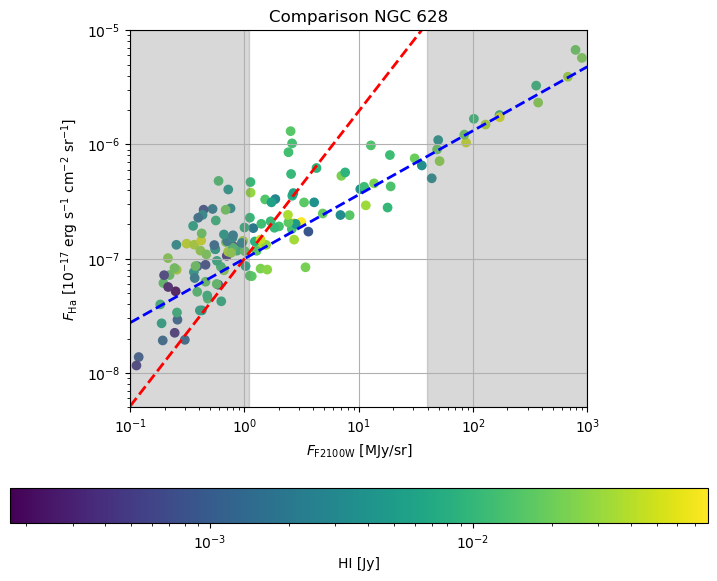

In [27]:
def rebin_image(image, bin_factor=21):
    shape = image.shape
    new_size = (shape[0] // bin_factor) * bin_factor
    image_cropped = image[:new_size, :new_size]
    image_rebinned = image_cropped.reshape(new_size // bin_factor, bin_factor, new_size // bin_factor, bin_factor).mean(axis=(1, 3))
    return image_rebinned

arcsec2_over_sr = 4.254791e10
image_IR_reb = rebin_image(image_IR_768)
image_Ha_reb = rebin_image(image_Ha_768  * arcsec2_over_sr)
image_HI_reb = rebin_image(image_HI_768)

fig, ax = plt.subplots(figsize=(9, 7))

cf = ax.scatter(image_IR_reb, image_Ha_reb, c=image_HI_reb, cmap='viridis', norm=LogNorm())

ax.set_xlabel(r'$F_{\mathrm{F2100W}}$ [MJy/sr]')
ax.set_ylabel(r'$F_{\mathrm{Ha}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'Comparison NGC 628')
ax.grid(True)

ax.axvspan(1e-1, 1.1e0, color='gray', alpha=0.3)
ax.axvspan(10**1.6, 1e3, color='gray', alpha=0.3)

ax.set_xlim(1e-1, 1e3)
ax.set_ylim(5e-9, 1e-5)

x_line = np.linspace(1e-1, 1e3, 100)
y_line = 1.29 * np.log10(x_line) - 7.
y_line2= 0.56 * np.log10(x_line) - 7.
ax.plot(x_line, 10**y_line, 'r--', lw=2)
ax.plot(x_line, 10**y_line2, 'b--', lw=2)

cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.15)
cbar.set_label(r'HI [Jy]')
ax.set_aspect('equal')
plt.savefig(f"{gallery_dir}Convergence_Leroy23.jpeg", format='jpeg', dpi=100)
plt.show()

# Power Spectra

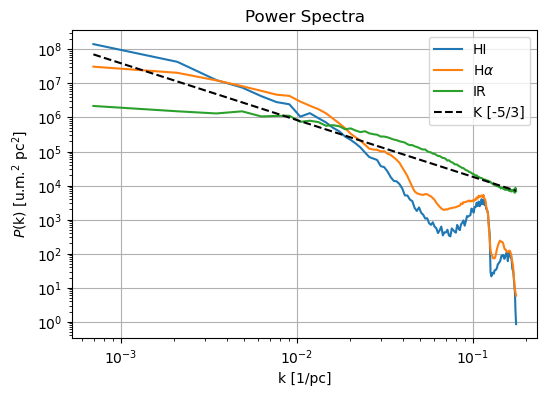

In [28]:
def compute_PS(img, pixel_scale_pc):
    img = (img - np.mean(img)) / np.std(img)
    ny, nx = img.shape
    ft_img = np.fft.fftshift(np.fft.fft2(img))
    power2D = np.abs(ft_img)**2

    dkx = 1.0 / (nx * pixel_scale_pc)
    dky = 1.0 / (ny * pixel_scale_pc)
    kx = np.fft.fftshift(np.fft.fftfreq(nx, d=pixel_scale_pc))
    ky = np.fft.fftshift(np.fft.fftfreq(ny, d=pixel_scale_pc))
    KX, KY = np.meshgrid(kx, ky)
    k = np.sqrt(KX**2 + KY**2)

    k_flat = k.flatten()
    power_flat = power2D.flatten()
    k_bins = np.linspace(0, k_flat.max(), min(nx, ny)//2)
    k_center = 0.5 * (k_bins[1:] + k_bins[:-1])
    Pk = np.zeros_like(k_center)

    for i in range(len(k_center)):
        mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
        if np.any(mask):
            Pk[i] = power_flat[mask].mean()
    return k_center, Pk

k_HI, PS_HI = compute_PS(image_HI_768, pixel_scale_pc = 4.0)
k_Ha, PS_Ha = compute_PS(image_Ha_768, pixel_scale_pc = 4.0)
k_IR, PS_IR = compute_PS(image_IR_768, pixel_scale_pc = 4.0)

P_kolm = k_HI**(-5/3)
P_kolm *= PS_HI.max() / P_kolm.max() * 0.5

plt.figure(figsize=(6,4))
plt.loglog(k_HI, PS_HI, label='HI')
plt.loglog(k_Ha, PS_Ha, label=r'H$\alpha$')
plt.loglog(k_IR, PS_IR, label='IR')
plt.loglog(k_HI, P_kolm, 'k--', label=r'K [-5/3]')
plt.xlabel('k [1/pc]')
plt.ylabel(r'$P$(k) [u.m.$^{2}$ pc$^{2}$]')
plt.title('Power Spectra')
plt.grid(True)
plt.legend()
plt.savefig(f"{gallery_dir}Convergence_PS.jpeg", format='jpeg', dpi=100)
plt.show()